# Omdena  - Milan Chapter Agrifoods
## AI for Sustainable agri-food systems: use of Satellite Imagery
### Exploratory analysis of cereals production in Italy 2020-2022
#### Author: Maria Fisher 


Here we have analysed the major areas and crop produced in Italy. 
Crop dataset used in this study was downloaded from the Italian National Institute of Statistics (Istat).
The objective is to get some insights about crop production and its respective areas in Italy and how climate change have affected crop production in the last 3 years. 
Maps was created with dataset from Simone Rigoni, the address to the repository of the dataset i avaialbe in References.   


In [1]:
import warnings 
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns 
import scipy 
import sklearn
import geopandas as gpd
import pgeocode
import folium
import sys
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

In [2]:
cereals = pd.read_csv('./Italy_crop_data/italy_cereals.csv',skipinitialspace=True)
cereals.head()

,ITTER107,Territory,TIPO_DATO5,Data type,AGRI_MADRE,Type of crop,TIME,Select time,Value,Flag Codes,Flags
0,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2020,2020,15362,NaN,NaN
1,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2021,2021,16831,NaN,NaN
2,ITC11,Torino,ART,total area - hectares,COMMEAT,common wheat,2022,2022,16735,NaN,NaN
3,ITC11,Torino,TP_QUIN_EXT,total production - quintals,COMMEAT,common wheat,2020,2020,844910,NaN,NaN
4,ITC11,Torino,TP_QUIN_EXT,total production - quintals,COMMEAT,common wheat,2021,2021,925705,NaN,NaN


## Pre-processing dataset 

In [3]:
# Drop Columns
cereals = cereals.drop(columns =['ITTER107','TIPO_DATO5','AGRI_MADRE', 'TIME', 'Flag Codes','Flags' ])
cereals

,Territory,Data type,Type of crop,Select time,Value
0,Torino,total area - hectares,common wheat,2020,15362
1,Torino,total area - hectares,common wheat,2021,16831
2,Torino,total area - hectares,common wheat,2022,16735
3,Torino,total production - quintals,common wheat,2020,844910
4,Torino,total production - quintals,common wheat,2021,925705
...,...,...,...,...,...
12125,Pesaro e Urbino,total area - hectares,rye and winter cereal mixtures (maslin),2022,3
12126,Roma,total area - hectares,rye and winter cereal mixtures (maslin),2022,20
12127,Valle d'Aosta / Vallée d'Aoste,total area - hectares,winter barley,2022,1
12128,Torino,total area - hectares,spring barley,2022,220


In [4]:
# Rename Columns
cereals = cereals.rename(columns = {'Select time':'Year', 'Type of crop':'Type_crop', 'Data type':'Data_type', 'Territory':'City'})


In [5]:
def show_info(cereals):
    print('DATASET SHAPE: ', cereals.shape, '\n')
    print('-'*50)
    print('FEATURE DATA TYPES:')
    print(cereals.info())
    print('\n', '-'*50)
    print('NUMBER OF UNIQUE VALUES PER FEATURE:', '\n')
    print(cereals.nunique())
    print('\n', '-'*50)
    print('NULL VALUES PER FEATURE')
    print(cereals.isnull().sum())
show_info(cereals)

DATASET SHAPE:  (12130, 5) 

--------------------------------------------------
FEATURE DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12130 entries, 0 to 12129
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City       12130 non-null  object
 1   Data_type  12130 non-null  object
 2   Type_crop  12130 non-null  object
 3   Year       12130 non-null  int64 
 4   Value      12130 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 474.0+ KB
None

 --------------------------------------------------
NUMBER OF UNIQUE VALUES PER FEATURE: 

City          107
Data_type       3
Type_crop      24
Year            3
Value        3103
dtype: int64

 --------------------------------------------------
NULL VALUES PER FEATURE
City         0
Data_type    0
Type_crop    0
Year         0
Value        0
dtype: int64


## Cities in Italy producing cereals

In [6]:
cereals.City.unique()


array(['Torino', 'Vercelli', 'Biella', 'Verbano-Cusio-Ossola', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', "Valle d'Aosta / Vallée d'Aoste",
       'Savona', 'Genova', 'La Spezia', 'Varese', 'Como', 'Lecco',
       'Sondrio', 'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Lodi',
       'Cremona', 'Mantova', 'Trentino Alto Adige / Südtirol', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Pordenone', 'Udine', 'Gorizia', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Massa-Carrara', 'Lucca', 'Pistoia',
       'Firenze', 'Prato', 'Livorno', 'Pisa', 'Arezzo', 'Siena',
       'Grosseto', 'Perugia', 'Terni', 'Pesaro e Urbino', 'Ancona',
       'Macerata', 'Ascoli Piceno', 'Viterbo', 'Rieti', 'Roma', 'Latina',
       'Frosinone', 'Abruzzo', "L'Aquila", 'Teramo', 'Pescara', 'Chieti',
       'Isernia', 'Campobasso', 'Caserta', 'Benevento', 'Avellino',
       'Salerno', 'Foggi

In [7]:
cereals.Data_type.unique()

array(['total area - hectares', 'total production - quintals ',
       'harvested production - quintals '], dtype=object)

## Select only Values for total production - quintals
In general crop production is reported in tonnes per hectare , however Istat (http://dati.istat.it) does not give variables definition, so we have assumed that the column 'Value' for rows containing data for 'harvested production - quintals', are values for total production of cereals. 

In [8]:
cereals_total_prod = cereals[cereals['Data_type'] == 'total production - quintals ']
cereals_total_prod.head()

,City,Data_type,Type_crop,Year,Value
3,Torino,total production - quintals,common wheat,2020,844910
4,Torino,total production - quintals,common wheat,2021,925705
5,Torino,total production - quintals,common wheat,2022,836750
12,Vercelli,total production - quintals,common wheat,2020,64250
13,Vercelli,total production - quintals,common wheat,2021,74550


In [9]:
cereals_total_prod = cereals_total_prod.rename(columns = {'Value':'Total_production'})
cereals_total_prod

,City,Data_type,Type_crop,Year,Total_production
3,Torino,total production - quintals,common wheat,2020,844910
4,Torino,total production - quintals,common wheat,2021,925705
5,Torino,total production - quintals,common wheat,2022,836750
12,Vercelli,total production - quintals,common wheat,2020,64250
13,Vercelli,total production - quintals,common wheat,2021,74550
...,...,...,...,...,...
12059,Trentino Alto Adige / Südtirol,total production - quintals,winter barley,2022,200
12064,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2021,1890
12065,Trentino Alto Adige / Südtirol,total production - quintals,spring barley,2022,1700
12070,Trentino Alto Adige / Südtirol,total production - quintals,oats and spring cereal mixtures (mixed grain o...,2021,372


In [10]:
cereals_total_prod =cereals_total_prod.drop(columns =['Data_type' ])
cereals_total_prod

,City,Type_crop,Year,Total_production
3,Torino,common wheat,2020,844910
4,Torino,common wheat,2021,925705
5,Torino,common wheat,2022,836750
12,Vercelli,common wheat,2020,64250
13,Vercelli,common wheat,2021,74550
...,...,...,...,...
12059,Trentino Alto Adige / Südtirol,winter barley,2022,200
12064,Trentino Alto Adige / Südtirol,spring barley,2021,1890
12065,Trentino Alto Adige / Südtirol,spring barley,2022,1700
12070,Trentino Alto Adige / Südtirol,oats and spring cereal mixtures (mixed grain o...,2021,372


## Total cereal production in 2020-2022

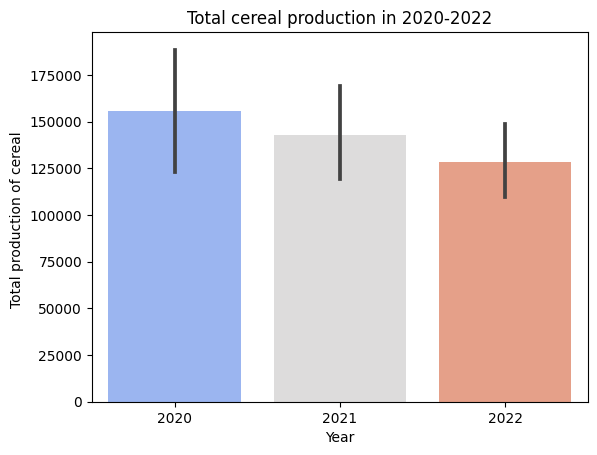

In [11]:

sns.barplot(x= 'Year', y= 'Total_production',data = cereals_total_prod,palette='coolwarm')
plt.title('Total cereal production in 2020-2022')
plt.xlabel('Year')
plt.ylabel('Total production of cereal ')
plt.show()



## Cereal production by Cities 

In [12]:
cereals_total_prod_region = cereals_total_prod.groupby(by = cereals_total_prod.City)['Total_production','City'].sum().reset_index().sort_values(by = 'Total_production', ascending = False).head(10)
cereals_total_prod_region

,City,Total_production
93,Torino,23124980
32,Ferrara,23066682
34,Foggia,22442368
65,Pavia,19838758
29,Cuneo,19837083
82,Rovigo,18998091
51,Mantova,18620664
62,Padova,18030596
100,Venezia,17475472
14,Bologna,16209589


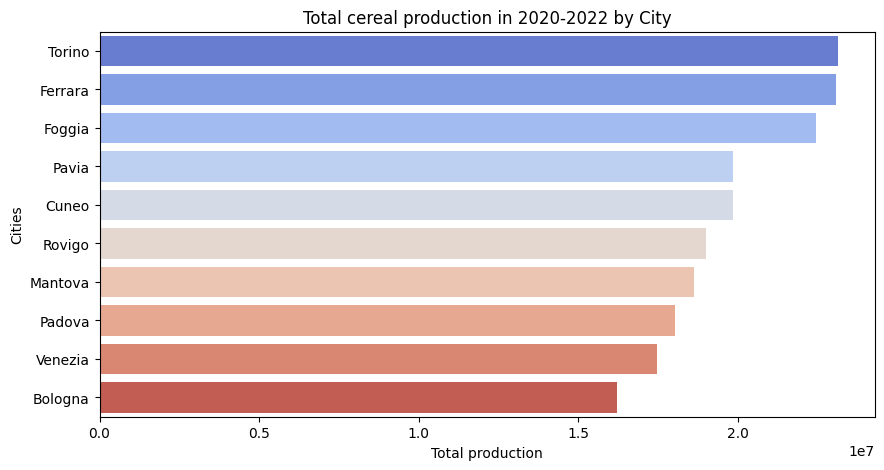

In [13]:
plt.figure(figsize= (10,5))
sns.barplot(x=cereals_total_prod_region['Total_production'],y= cereals_total_prod_region['City'], orient='h', palette='coolwarm');
plt.title('Total cereal production in 2020-2022 by City')
plt.xlabel('Total production')
plt.ylabel('Cities')
plt.show()

## Italy geographic areas is organized in regions, provinces or comunes. 
### The regions are classified as follow:


#### Sud/Mezzogiorno:  

Abruzzo, Apulia/Puglia, Basilicata, Calabria, Campania, Molise, Sicily 

* Abruzzo: L'Aquila, Pescara, Chieti, Teramo

* Apulia/Puglia: Foggia, Bari, Taranto, Brindisi, Lecce, Barletta-Andria-Trani

* Basilicata: Matera, Potenza

* Calabria: Crotone, Vibo, Valentia, Cosenza, Catanzaro, Reggio di Calabria

* Campania: Benevento, Caserta, Napoli, Avellino, Salerno

* Molise: Campobasso, Isernia

* Sicilia: Messina,Siracusa, Agrigento, Caltanissetta, Trapani, Enna, Palermo, Catania, Ragusa

* Sardegna: Oristano, Carbonia-Iglesias, Olbia-Tempio, Ogliastr, Medio Campidano, Sassari, Nuoro, Cagliari



#### Centro: 

Toscana, Umbria, Marche, Lazio

* Toscana: Pistoia, Firenze, Massa-Carrara, Lucca, Arezzo, Livorno, Pisa, Grosseto, Siena, Prato

* Umbria: Perugia, Terni   

* Marche: Ancona, Macerata, Ascoli Piceno, Pesaro e Urbino, Fermo

* Lazio:  Roma, Viterbo, Rieti, Latina, Frosinone


#### Nord-ovest: 

Piemonte, Valle d’Aosta, Lombardia, Liguria

* Liguria: Imperia, Savona, Genova, La Spezia

* Lombardia: Como, Varese, Milano, Pavia, Bergamo, Brescia, Sondrio, Cremona, Mantova, Monza e Della Brianza, Lecco,Lodi

* Piemonte: Vercelli, Novara, Torino, Cuneo, Asti, Alessandria, Biella, Verbano-Cusio-Ossola

* Valdaosta:  Valle d'Aosta


#### Nord-est:

Trentino-Alto Adige, Veneto, Fiuli-Venezia Giulia, Emilia-Romagna


* Trentino: Bolzano/Bozen, Trento

* Veneto:  Belluno, Verona, Vicenza, Rovigo, Treviso, Venezia, Padova

* Friuli: Udine, Gorizia, Trieste, Pordenone

* Emilia-Romagna: Parma, Reggio Nell'Emilia, Piacenza, Forli'-Cesena, Modena, Bologna, Ferrara, Ravenna, Rimini











## Cereals highest production 2020-2022

In [14]:
print(cereals_total_prod.Type_crop.max())
print(cereals_total_prod.Type_crop.value_counts())
print(cereals_total_prod.Type_crop.nunique())



winter cereal mixtures (maslin)
barley                                                             300
oats                                                               290
durum wheat                                                        286
common wheat                                                       284
grain maize                                                        284
broad bean                                                         241
chick-peas                                                         235
other cereals                                                      226
dried kidney bean                                                  221
oats and spring cereal mixtures (mixed grain other than maslin)    195
protein pea                                                        193
winter barley                                                      187
common winter wheat and spelt                                      174
lentil                                       

Dataset shows there are 24 different types of cereals cultivated in Italy. The top five most produced crops are Wheat, Barley, Maize, Beans and Oats. 

In [15]:
cereals_total_prod.describe()

,Year,Total_production
count,4042.000000,4.042000e+03
mean,2021.082880,1.411529e+05
std,0.788942,4.820117e+05
min,2020.000000,0.000000e+00
25%,2020.000000,7.200000e+02
50%,2021.000000,5.032500e+03
75%,2022.000000,6.392000e+04
max,2022.000000,7.500000e+06


<AxesSubplot: >

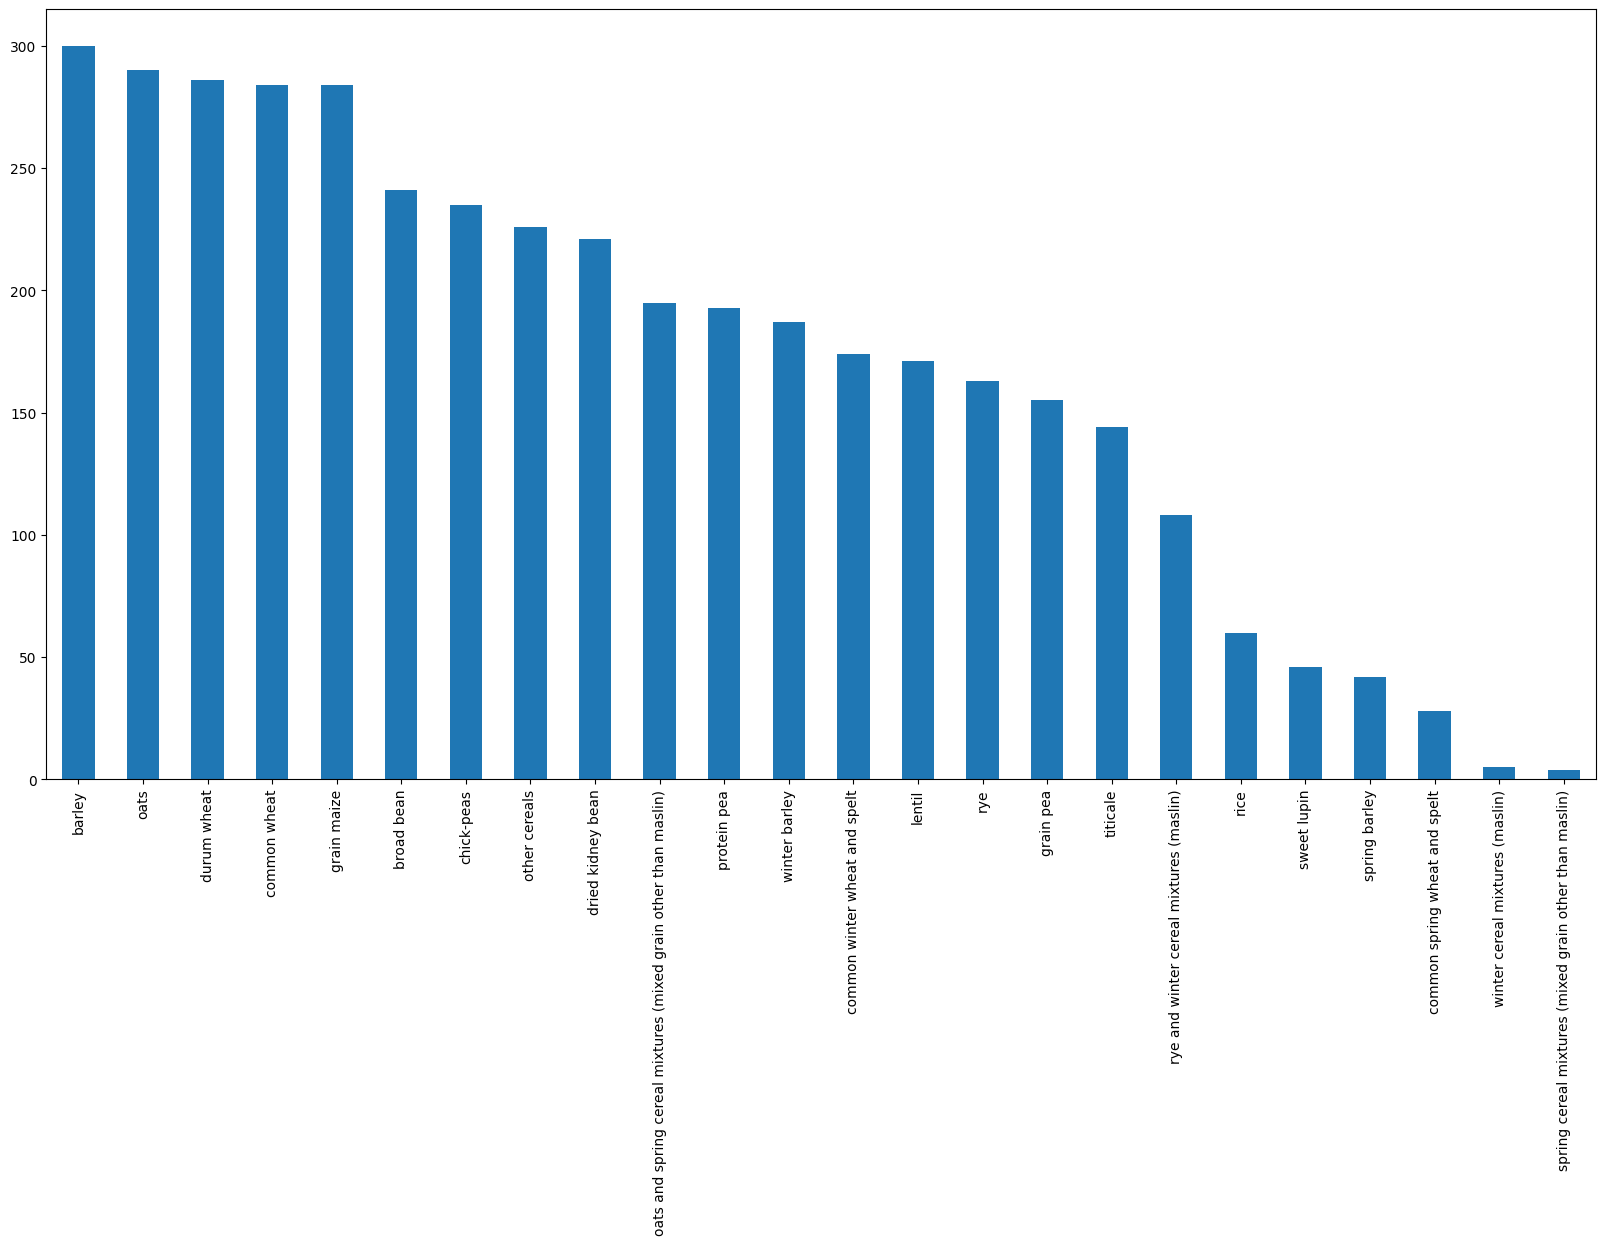

In [16]:
plt.figure(figsize=(20,10))
cereals_total_prod ['Type_crop'].value_counts().plot.bar()

## Subseting data

In [17]:
cereals_top5 = cereals_total_prod.apply(lambda row: row[cereals_total_prod['Type_crop'].isin(['barley','oats', 
                                         'durum wheat','common wheat', 'grain maize'])])

cereals_top5.head()

,City,Type_crop,Year,Total_production
3,Torino,common wheat,2020,844910
4,Torino,common wheat,2021,925705
5,Torino,common wheat,2022,836750
12,Vercelli,common wheat,2020,64250
13,Vercelli,common wheat,2021,74550


## Stats

In [18]:
cereals_top5.describe().astype(int)

,Year,Total_production
count,1444,1444
mean,2020,304659
std,0,696586
min,2020,0
25%,2020,5606
50%,2021,62000
75%,2022,232845
max,2022,7500000


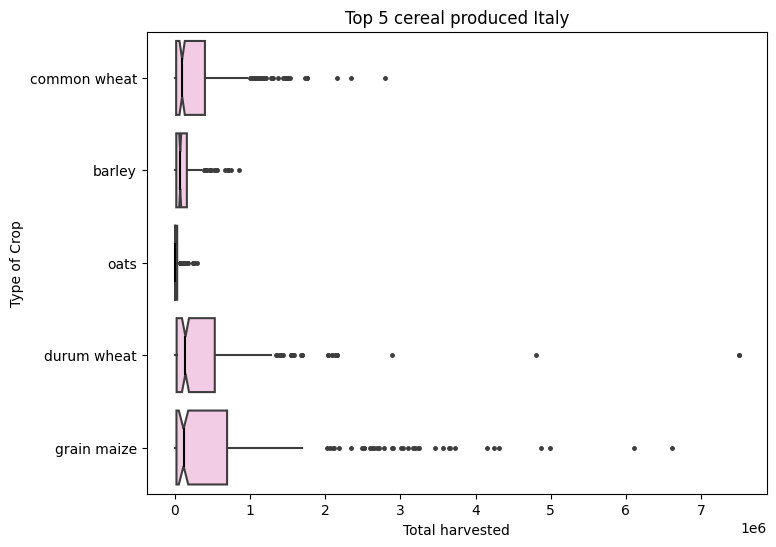

In [19]:
plt.figure(figsize=(8,6))

sns.boxplot(
    data=cereals_top5, y="Type_crop", x="Total_production",
    notch=True, showcaps=False,
    flierprops={"marker": "."},
    boxprops={"facecolor": (.9, .6, .8, .5)},
    medianprops={"color": "black"},
)
plt.title('Top 5 cereal produced Italy')
plt.ylabel('Type of Crop')
plt.xlabel('Total harvested')
plt.show()

## Vizualization of five type of cereal produced in Italy in the period of 2020-2022 

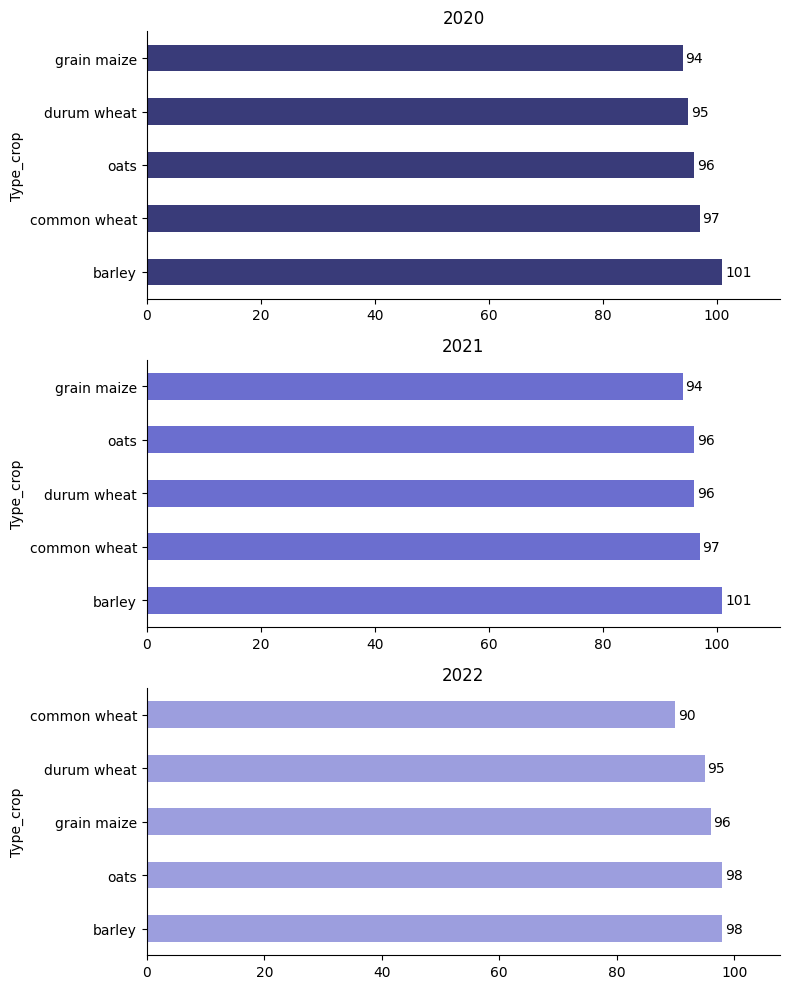

In [20]:
fig, axs = plt.subplots(3, figsize=(8, 10))

plot1 = cereals_top5[cereals_top5.Year == 2020].groupby('Type_crop').size().nlargest(5).plot(kind='barh', color='#393b79', title='2020', ax=axs[0])
plot2 = cereals_top5[cereals_top5.Year == 2021].groupby('Type_crop').size().nlargest(5).plot(kind='barh', color='#6b6ecf', title='2021', ax=axs[1])
plot3 = cereals_top5[cereals_top5.Year == 2022].groupby('Type_crop').size().nlargest(5).plot(kind='barh', color='#9c9ede', title='2022', ax=axs[2])

for ax in axs.flat:
    ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge', padding=2)
    ax.margins(x=0.1)
sns.despine()
plt.tight_layout()
plt.show()

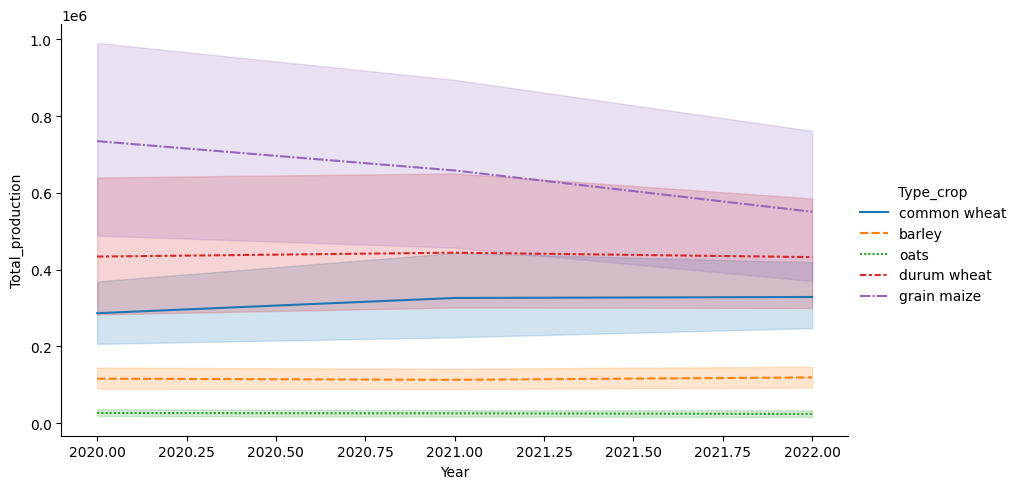

In [21]:
#Crop harvested by year
plotcrop5 = sns.relplot(kind='line', data=cereals_top5, x='Year', y='Total_production', hue='Type_crop', style='Type_crop', aspect=1.75)


In [22]:
# Select year 2020 for future join with fertilizer
it_crop2020 = cereals_top5[cereals_top5['Year'] == 2020]
it_crop2020



,City,Type_crop,Year,Total_production
3,Torino,common wheat,2020,844910
12,Vercelli,common wheat,2020,64250
21,Biella,common wheat,2020,5590
30,Verbano-Cusio-Ossola,common wheat,2020,130
39,Novara,common wheat,2020,60550
...,...,...,...,...
8605,Sud Sardegna,durum wheat,2020,396335
8614,Bolzano / Bozen,common wheat,2020,1400
8632,Bolzano / Bozen,barley,2020,2205
8641,Bolzano / Bozen,oats,2020,352


### Pre-processing ferlizers dataset

In [23]:
fertilizer = pd.read_csv('italy_fertilizers.csv',skipinitialspace=True)
fertilizer.head()

,ITTER107,Territory,TIPO_DATO5,Data type,FERTILIZZANTI,Type of fertilizer,TIME,Select time,Value,Flag Codes,Flags
0,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2019,2019,11,NaN,NaN
1,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2020,2020,11,NaN,NaN
2,ITD59,Rimini,FERT_DISTRIB_T,fertilizers distributed - tonnes,CON_MIN_MICRO,containing micronutrients,2021,2021,3,NaN,NaN
3,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2019,2019,8,NaN,NaN
4,ITD44,Trieste,FERT_DISTRIB_T,fertilizers distributed - tonnes,AMM_TORB_COMP,peaty soil amendment,2020,2020,105,NaN,NaN


In [24]:
fertilizer = fertilizer.drop(columns =['ITTER107','TIPO_DATO5', 'TIME','FERTILIZZANTI','Flag Codes','Flags' ])
fertilizer

,Territory,Data type,Type of fertilizer,Select time,Value
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [25]:
fertilizer.Territory.unique()

array(['Rimini', 'Trieste', 'Pisa', 'Pordenone', 'Venezia', 'Firenze',
       'Perugia', 'Enna', 'Nuoro', 'Ferrara', 'Bologna', 'Ascoli Piceno',
       'Roma', 'Verona', 'Messina', 'Parma', 'Oristano', 'Siena',
       'Vibo Valentia', 'Monza e della Brianza', 'Varese', 'Novara',
       'Lecco', 'Grosseto', 'Rieti', 'Pavia', 'Ancona', 'Pesaro e Urbino',
       'Forlì-Cesena', 'Reggio di Calabria', 'Chieti', 'Cremona', 'Udine',
       'Lecce', 'Avellino', 'Potenza', 'Lucca', 'Padova', 'Gorizia',
       'Savona', 'Pescara', 'Caltanissetta', 'Brescia',
       'Trentino Alto Adige / Südtirol', 'Benevento', 'Viterbo',
       'Sassari', 'Treviso', 'Como', 'Provincia Autonoma Bolzano / Bozen',
       'Teramo', 'Latina', 'Catania', "Valle d'Aosta / Vallée d'Aoste",
       'Verbano-Cusio-Ossola', 'Belluno', 'Catanzaro', 'Genova',
       'Sondrio', 'Modena', 'Alessandria', 'Piacenza', 'Caserta',
       'Isernia', 'Prato', 'Arezzo', 'Agrigento', 'Matera', 'Cagliari',
       'Pistoia', 'Salerno', '

In [26]:
# change name of columns
fertilizer = fertilizer.rename(columns = {'Select time':'Year', 'Type of fertilizer':'Type_fertilizer', 'Data type':'Data_type', 'Territory':'City', 'Value':'Fertilizers_tonnes'})
fertilizer

,City,Data_type,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,fertilizers distributed - tonnes,containing micronutrients,2019,11
1,Rimini,fertilizers distributed - tonnes,containing micronutrients,2020,11
2,Rimini,fertilizers distributed - tonnes,containing micronutrients,2021,3
3,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2019,8
4,Trieste,fertilizers distributed - tonnes,peaty soil amendment,2020,105
...,...,...,...,...,...
17670,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,422
17671,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2021,543
17672,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2019,164
17673,Sud Sardegna,fertilizers distributed - tonnes,specific action products -,2020,135


In [27]:
# drop column 
fertilizer = fertilizer.drop(columns =['Data_type'])
fertilizer

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Rimini,containing micronutrients,2019,11
1,Rimini,containing micronutrients,2020,11
2,Rimini,containing micronutrients,2021,3
3,Trieste,peaty soil amendment,2019,8
4,Trieste,peaty soil amendment,2020,105
...,...,...,...,...
17670,Sud Sardegna,specific action products -,2020,422
17671,Sud Sardegna,specific action products -,2021,543
17672,Sud Sardegna,specific action products -,2019,164
17673,Sud Sardegna,specific action products -,2020,135


In [28]:
# Select year 2020 for future join with fertilizer
fertilizer2020 = fertilizer[fertilizer['Year'] == 2020]
fertilizer2020

,City,Type_fertilizer,Year,Fertilizers_tonnes
1,Rimini,containing micronutrients,2020,11
4,Trieste,peaty soil amendment,2020,105
7,Pisa,specific action products,2020,27
10,Pordenone,three components - nitrogen-phosphorous-phosph...,2020,8547
13,Venezia,soil correctives - sulphur for agricultural use,2020,5
...,...,...,...,...
17661,Sud Sardegna,soil correctives - other soil correctives,2020,2
17664,Sud Sardegna,crop substrates,2020,112
17667,Sud Sardegna,specific action products,2020,557
17670,Sud Sardegna,specific action products -,2020,422


#### Selecting only 6 type of fertilizers for future analysis 

In [29]:
fertilizer2020.Type_fertilizer.unique()

array(['containing micronutrients', 'peaty soil amendment',
       'specific action products',
       'three components - nitrogen-phosphorous-phosphorous',
       'soil correctives - sulphur for agricultural use',
       'two components - nitrogen-potassium',
       'containing micronutrients containing only a micronutrient',
       'organic fertilizers - compound', 'manure amendment',
       'vegetable soil amendment',
       'containing micronutrients containing several micronutrients in chelated form',
       'organic fertilizers - straight nitrogen',
       'other fertilizers different from sulphate and chloride ',
       'two components - phosphorus-potassium',
       'mineral fertilizers containing macronutrients and micronutrients',
       'triple superphosphate',
       'organic-mineral fertilizers - straight nitrogen',
       'other soil amendments',
       'containing only one secondary macronutrient - sulphur oxide',
       'containing micronutrients containing only a micro

In [30]:
print(fertilizer2020.Type_fertilizer.max())
print(fertilizer2020.Type_fertilizer.value_counts())
print(fertilizer2020.Type_fertilizer.nunique())

vegetable soil amendment
specific action products -                                                               216
containing micronutrients                                                                120
mineral fertilizers containing macronutrients and micronutrients                         120
containing macronutrients                                                                120
potassium fertilizers                                                                    120
organic fertilizers                                                                      120
nitrogen fertilizers                                                                     120
simple mineral fertilizers                                                               120
compound mineral fertilizers                                                             120
crop substrates                                                                          120
organic-mineral fertilizers                  

In [31]:
fertilizer6 = fertilizer2020.apply(lambda row: row[fertilizer2020['Type_fertilizer'].isin(['nitrogen fertilizers','potassium fertilizers',
                                                                                   'organic fertilizers', 'phosphorus fertilizers',
                                                                                   'calcium cyanamide', 'ammonium sulphate'])])

fertilizer6.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
76,Pavia,ammonium sulphate,2020,747
154,Benevento,calcium cyanamide,2020,0
166,Treviso,ammonium sulphate,2020,1423
172,Provincia Autonoma Bolzano / Bozen,nitrogen fertilizers,2020,31
235,Alessandria,organic fertilizers,2020,2251


#### Create new dataframe with the selected type of fertilizers as columns  

In [32]:
# Create columns for each type of fertilizer 
fertilizer6_pivot = fertilizer6.pivot_table(index=['City', 'Year'],aggfunc='sum', columns='Type_fertilizer',values=['Fertilizers_tonnes'])
fertilizer6_pivot

Fertilizers_tonnes                                         \
Type_fertilizer     ammonium sulphate calcium cyanamide nitrogen fertilizers   
City          Year                                                             
Agrigento     2020                155                12                 1715   
Alessandria   2020                135               105                20968   
Ancona        2020                567                17                22511   
Arezzo        2020                 68                26                 3675   
Ascoli Piceno 2020                  8               158                 1065   
...                               ...               ...                  ...   
Vercelli      2020                 14              2570                 7604   
Verona        2020               3919               258                66460   
Vibo Valentia 2020               1433                 0                 2487   
Vicenza       2020               1350               225                10182   
Viterbo       2020                176                 0                14138   

                                                               \
Type_fertilizer    organic fertilizers phosphorus fertilizers   
City          Year                                              
Agrigento     2020                4006                    142   
Alessandria   2020                2251                    782   
Ancona        2020                2695                   1258   
Arezzo        2020                2053                     72   
Ascoli Piceno 2020                1284                     22   
...                                ...                    ...   
Vercelli      2020                6585                      0   
Verona        2020                9529                   9363   
Vibo Valentia 2020                  92                    157   
Vicenza       2020                1252                    220   
Viterbo       2020                2673                    603   

                                          
Type_fertilizer    potassium fertilizers  
City          Year                        
Agrigento     2020                    16  
Alessandria   2020                   743  
Ancona        2020                    33  
Arezzo        2020                   209  
Ascoli Piceno 2020                   267  
...                                  ...  
Vercelli      2020                  1013  
Verona        2020                  6141  
Vibo Valentia 2020                     0  
Vicenza       2020                   351  
Viterbo       2020                    10  

[108 rows x 6 columns]

In [33]:
# Drop level
fertilizer6_pivot.columns = fertilizer6_pivot.columns.droplevel()
fertilizer6_pivot

,Type_fertilizer,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [34]:
#Rename index
fertilizer6_pivot = fertilizer6_pivot.rename_axis(None,axis=1)
fertilizer6_pivot

,,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
City,Year,,,,,,
Agrigento,2020,155,12,1715,4006,142,16
Alessandria,2020,135,105,20968,2251,782,743
Ancona,2020,567,17,22511,2695,1258,33
Arezzo,2020,68,26,3675,2053,72,209
Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...
Vercelli,2020,14,2570,7604,6585,0,1013
Verona,2020,3919,258,66460,9529,9363,6141
Vibo Valentia,2020,1433,0,2487,92,157,0


In [35]:
# Reset index
fertilizer6_pivot = fertilizer6_pivot.reset_index()
fertilizer6_pivot

,City,Year,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Agrigento,2020,155,12,1715,4006,142,16
1,Alessandria,2020,135,105,20968,2251,782,743
2,Ancona,2020,567,17,22511,2695,1258,33
3,Arezzo,2020,68,26,3675,2053,72,209
4,Ascoli Piceno,2020,8,158,1065,1284,22,267
...,...,...,...,...,...,...,...,...
103,Vercelli,2020,14,2570,7604,6585,0,1013
104,Verona,2020,3919,258,66460,9529,9363,6141
105,Vibo Valentia,2020,1433,0,2487,92,157,0
106,Vicenza,2020,1350,225,10182,1252,220,351


#### Join crop and fertilizers datasets 

In [36]:
# Join both datasets 
it_crop_ferlizer = pd.merge(it_crop2020, fertilizer6_pivot, on=['Year', 'City'], how='left')
it_crop_ferlizer

,City,Type_crop,Year,Total_production,ammonium sulphate,calcium cyanamide,nitrogen fertilizers,organic fertilizers,phosphorus fertilizers,potassium fertilizers
0,Torino,common wheat,2020,844910,107.0,356.0,33960.0,1973.0,105.0,7653.0
1,Vercelli,common wheat,2020,64250,14.0,2570.0,7604.0,6585.0,0.0,1013.0
2,Biella,common wheat,2020,5590,0.0,18.0,379.0,127.0,0.0,15.0
3,Verbano-Cusio-Ossola,common wheat,2020,130,0.0,0.0,0.0,18.0,0.0,0.0
4,Novara,common wheat,2020,60550,151.0,882.0,7034.0,1723.0,56.0,1137.0
...,...,...,...,...,...,...,...,...,...,...
478,Sud Sardegna,durum wheat,2020,396335,6.0,0.0,430.0,138.0,7.0,59.0
479,Bolzano / Bozen,common wheat,2020,1400,NaN,NaN,NaN,NaN,NaN,NaN
480,Bolzano / Bozen,barley,2020,2205,NaN,NaN,NaN,NaN,NaN,NaN
481,Bolzano / Bozen,oats,2020,352,NaN,NaN,NaN,NaN,NaN,NaN


### Correlation analysis

In [37]:
 it_crop_ferlizer = it_crop_ferlizer[['Type_crop','Total_production','ammonium sulphate','calcium cyanamide','nitrogen fertilizers',
                                      'organic fertilizers','phosphorus fertilizers','potassium fertilizers']] 

In [38]:

crop = it_crop_ferlizer.Type_crop.astype('category')
targets = dict(enumerate(crop.cat.categories))
it_crop_ferlizer['target']=crop.cat.codes

cor_selected = it_crop_ferlizer[['Total_production','ammonium sulphate','calcium cyanamide','nitrogen fertilizers',
                       'organic fertilizers','phosphorus fertilizers','potassium fertilizers']]


<AxesSubplot: title={'center': 'Correlation'}>

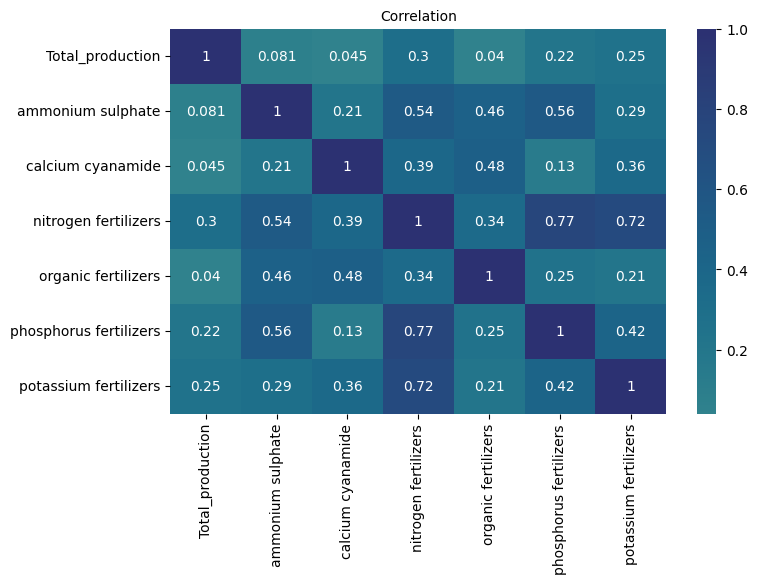

In [39]:
plt.figure(figsize=(8,5))
plt.title('Correlation', size=10)
sns.heatmap(cor_selected.corr(), cmap='crest', center=0, annot=True)

The correlation analysis shows that total cereal production in Italy with correlation greater or equal to 0.5 between phosphorus and potassium with nitrogen fertilizer.


Modelling 

# References


http://dati.istat.it

https://maps.princeton.edu/catalog/stanford-mn871sp9778

https://www.crea.gov.it/documents/68457/0/ITACONTA+2020_ENG+DEF+xweb+%281%29.pdf/95c6b30a-1e18-8e94-d4ac-ce884aef76e8?t=1619527317576

https://seaborn.pydata.org/generated/seaborn.relplot.html